# "Spider" Plot Instructions

Everything should be run from the base larnd-sim directory (`larnd-sim`)

1. Use `gen_configs.py` to generate batch submission files for all desired simulations. Lots of hardcoded stuff in there, but this does 10 noise samples for nominal parameters, + 20 points in parameter ranges for each parameter

2. Submit these all (`sbatch configs/shift_<param>_<val>_submit.sh`). May be easiest to just do a quick bash for loop: `for file in configs/*; do sbatch $file; done`. This runs `run_batch_sim.py` for each desired simulation. Again some hardcoding, but settings should be ok. Lots of jobs submitted, but they're all pretty quick.

3. Collect dtw values for plotting. You can use the scripts in `configs_collect` (`sbatch configs_collect/<file>`), for loop should work ok. `collect.sh` is for the no noise in target case, and then each of the `collect_noisy_targ*.sh` scripts is for a different noise sample of the noise in target case. These run `collect_dtws.py` and `collect_dtws_compare_to_noise.py` respectively.

4. Run this notebook to plot.

In [5]:
import torch
import os
import sys
sys.path.insert(0, "../")

from optimize.ranges import ranges
from tqdm import tqdm
import matplotlib.pyplot as plt

import pickle
import numpy as np

In [2]:
import numpy as np
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [3]:
param_list = ['Ab', 'kb', 'lifetime', 'long_diff', 'tran_diff', 'eField']

In [4]:
# Calculate 1 percent diff to use as baseline
target_file_dir = "../nominal_vals_batch/"
shift_1_perc = []
for file in os.listdir(target_file_dir):
    full_path_target = os.path.join(target_file_dir, file)

    target = torch.load(full_path_target).cpu().numpy()[-1]
    
    target_up_1 = target*1.01
    target_down_1 = target*0.99

    dtw_val_up = dtw(target_up_1, target)[-1][-1]
    dtw_val_down = dtw(target_down_1, target)[-1][-1]
    shift_1_perc.append((dtw_val_up+dtw_val_down)/2)

In [ ]:
# Note: I combined these into one file and then deleted, so this hasn't been run, but
# the samples for a target with no noise can be aggregated like this -- could do calculation 
# of plot values at this stage as well, sim to noisy case
all_dist = {}
for param in param_list+['noise']:
    param_dict = pickle.load(open(f"../collect_adc_dtw_{param}.pkl", "rb"))
    key_vals = list(param_dict[param].keys())
    
    all_dist[param] = {}
    for val in key_vals:
        all_dist[param][val] = param_dict[param][val]

In [7]:
legend_labels = {
    'Ab' : "$A_{B}$",
    'kb' : "$k_{B}$",
    'eField' : "$\\epsilon$",
    'lifetime' : "$\\tau$",
    'long_diff' : "$D_{L}$",
    'tran_diff' : "$D_{T}$"
}

In [9]:
# Get noise baseline
all_noisy_things = np.concatenate([(np.asarray(all_dist["noise"][i])/np.asarray(shift_1_perc))
                                   for i in all_dist['noise'].keys()])
median_noise = np.median(all_noisy_things)
down_noise = np.percentile(all_noisy_things, 25)
up_noise = np.percentile(all_noisy_things, 75)

In [10]:
# Calculate means across 10 noise samples for curves comparing to noisy target
noisy_target = {}
for param in param_list:
    all_x_vals = []
    all_y_vals = []
    all_perc_25_vals = []
    all_perc_75_vals = []
    
    noisy_target[param] = {}
    for sample in range(10):
        test = pickle.load(open(f"../collect_adc_dtw_{param}_vs_noisy_target_sample{sample}.pkl", "rb"))
        x_vals = (np.asarray(list(test[param].keys()))/ranges[param]['nom']-1)*100
        key_vals = list(test[param].keys())
        y_vals = [np.median(np.asarray(test[param][val])/np.asarray(shift_1_perc)) for val in key_vals]
        perc25_vals = [np.percentile(np.asarray(test[param][val])/np.asarray(shift_1_perc), 25) for val in key_vals]
        perc75_vals = [np.percentile(np.asarray(test[param][val])/np.asarray(shift_1_perc), 75) for val in key_vals]
        
        all_x_vals.append(x_vals)
        all_y_vals.append(y_vals)
        all_perc_25_vals.append(perc25_vals)
        all_perc_75_vals.append(perc75_vals)
        
    noisy_target[param]['x_vals'] = np.mean(all_x_vals, axis=0)
    noisy_target[param]['y_vals'] = np.mean(all_y_vals, axis=0)
    noisy_target[param]['perc_25_vals'] = np.mean(all_perc_25_vals, axis=0)
    noisy_target[param]['perc_75_vals'] = np.mean(all_perc_75_vals, axis=0)

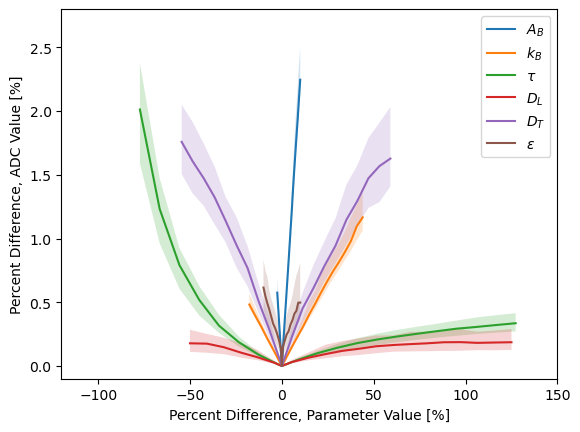

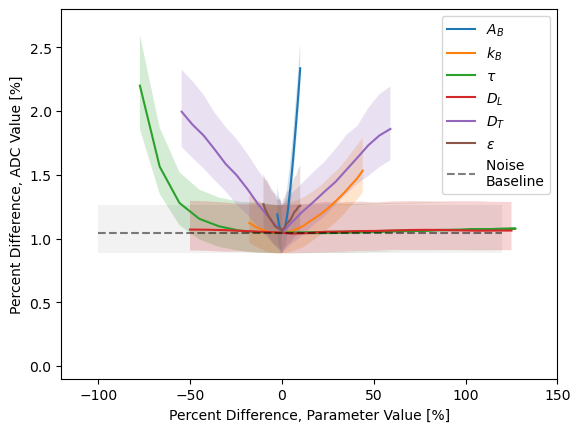

In [11]:
# Make plots
for i, param in enumerate(all_dist.keys()):
    if param == "noise":
        continue
        
    idxs = np.argsort(np.asarray(list(all_dist[param].keys())))
    x_vals = np.asarray(list(all_dist[param].keys()))[idxs]
    y_vals = np.asarray([np.median(np.asarray(all_dist[param][val])/np.asarray(shift_1_perc)) for val in x_vals])
    y_vals_down = np.asarray([np.percentile(np.asarray(all_dist[param][val])/np.asarray(shift_1_perc), 25) for val in x_vals])
    y_vals_up = np.asarray([np.percentile(np.asarray(all_dist[param][val])/np.asarray(shift_1_perc), 75) for val in x_vals])
    
    # Difference between nominal and nominal is 0
    idx = np.searchsorted(x_vals,ranges[param]['nom'])
    
    xvals_new = np.insert(x_vals, idx, ranges[param]['nom'])
    yvals_new = np.insert(y_vals, idx, 0)
    yvals_down_new = np.insert(y_vals_down, idx, 0)
    yvals_up_new = np.insert(y_vals_up, idx, 0)
    
    plt.plot((xvals_new/ranges[param]['nom']-1)*100,
              yvals_new, label=legend_labels[param])
    
    plt.fill_between((xvals_new/ranges[param]['nom']-1)*100,
                      yvals_down_new, yvals_up_new, facecolor=f'C{i}', alpha=0.2)
    

plt.xlim(-120, 150)
plt.ylim(-0.1, 2.8)

plt.xlabel("Percent Difference, Parameter Value [%]")
plt.ylabel("Percent Difference, ADC Value [%]")

plt.legend()
#plt.savefig('spider_plot_all_batches_with_noisy_comparison_no_noise.pdf', bbox_inches='tight')
plt.show()

for i, param in enumerate(all_dist.keys()):
    if param == "noise":
        plt.plot([-100, 120], [median_noise]*2, c='k', ls='dashed', label="Noise \nBaseline", alpha=0.5)
        plt.fill_between([-100, 120], [down_noise]*2, [up_noise]*2, facecolor='k', alpha=0.05)
        continue
        
    idx = np.searchsorted(noisy_target[param]['x_vals'], ranges[param]['nom'])
    
    noisy_target[param]['x_vals_new'] = np.insert(noisy_target[param]['x_vals'], idx, 0)
    noisy_target[param]['y_vals_new'] = np.insert(noisy_target[param]['y_vals'], idx, median_noise)
    noisy_target[param]['perc_25_vals_new'] = np.insert(noisy_target[param]['perc_25_vals'], idx, down_noise)
    noisy_target[param]['perc_75_vals_new'] = np.insert(noisy_target[param]['perc_75_vals'], idx, up_noise)

    plt.plot(noisy_target[param]['x_vals_new'], noisy_target[param]['y_vals_new'], c=f'C{i}',
               label=legend_labels[param])
    plt.fill_between(noisy_target[param]['x_vals_new'], noisy_target[param]['perc_25_vals_new'], noisy_target[param]['perc_75_vals_new'],
                      facecolor=f'C{i}', alpha=0.2)
    
plt.xlim(-120, 150)
plt.ylim(-0.1, 2.8)

plt.xlabel("Percent Difference, Parameter Value [%]")
plt.ylabel("Percent Difference, ADC Value [%]")

plt.legend()
#plt.savefig('spider_plot_all_batches_with_noisy_comparison_with_noise.pdf', bbox_inches='tight')
    
plt.show()